Searching for devices...
Found and connected to: Keysight Technologies,RP7972A,MY60000638,B.06.05.1049

[4.232998, 4.194863, 4.109059, 4.042323, 3.966052, 3.927917, 3.946985, 3.956519, 3.918383, 3.842113, 3.78491, 3.775377, 3.727708, 3.670505, 3.603769, 3.537032, 3.517965, 3.47983, 3.422627, 3.384492, 3.365424, 3.317755, 3.317755, 3.346357, 3.327289, 3.270087, 3.231951, 3.184282, 3.155681, 3.117546, 3.079411, 3.031742, 2.993607, 2.955472, 2.907803, 2.860134, 2.821999, 2.783864, 2.745728, 2.726661, 2.688526, 2.650391, 2.631323, 2.640857, 2.650391, 2.650391, 2.602722, 2.535985, 2.478783, 2.459715, 2.42158, 2.383445, 2.34531, 2.297641, 2.249972, 2.249972, 2.249972, 2.211837, 2.173702, 2.164168, 2.154634, 2.135567, 2.126033, 2.06883, 2.030695, 2.002094, 1.944891, 1.925823, 1.954425, 1.973492, 1.935357, 1.925823, 1.925823, 1.868621, 1.811418, 1.773283, 1.735148, 1.687479, 1.668411, 1.658878, 1.630276, 1.620743, 1.592141, 1.554006, 1.573074, 1.554006, 1.525405, 1.525405, 1.534939, 1.534939, 

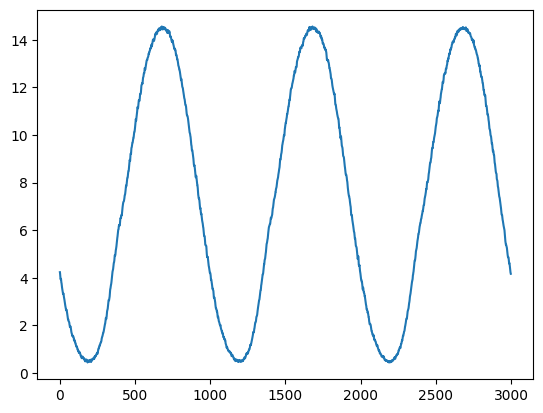

In [17]:
import numpy as np
import pyvisa
import time
import matplotlib.pyplot as plt

class RP7972A():
    """Esta clase pide y mide los datos de la fuente, para luego ser procesados"""
    def __init__(self, rp_USB=None):
        """Define variables de entrada como variables globales en la clase"""

        self.rp_USB=rp_USB
        # FOR INITIALIZATION OF POWER SOURCE (RP7972A)
        rm = pyvisa.ResourceManager()
        devices = rm.list_resources()

        print("Searching for devices...")
        for device in devices:
            try:
                my_instrument = rm.open_resource(str(device))
                device_ID=my_instrument.query('*IDN?')
                if  "RP797" in device_ID:#if the RP7972 is found assign it to rp_USB
                    self.rp_USB=my_instrument
                    print("Found and connected to: "+device_ID)
                    break
                else:#close other devices
                    my_instrument.close()
            except:
                print("no devices were found")
                
        if not self.rp_USB:
                print("No RP7972 power supply was found.")
                rm.close()

        

        
    def measure_voltage(self, measure_time, measure_points):
        """Query the device for voltage points using the MEASure:ARRay:VOLTage[:DC]? command"""
        self.scpi_out(" SENS:SWE:TINT " + str(measure_time) )
        self.scpi_out(" SENS:SWE:POIN " + str(measure_points))
        self.scpi_out("TRIG:ACQ:SOUR TRAN")
        self.scpi_out("INIT:ACQ")
        time.sleep(0.1) #it would be best to query the statur of the ACQ system
        self.scpi_out(" TRIG:ACQ")
        time.sleep(1.5) #it would be best to query the active measurment status to fetch measurement after it is done
        #points = self.rp_USB.query("FETC:ARR:VOLT?")
        points=self.rp_USB.query_ascii_values("FETC:ARR:VOLT?","f",",",)
        return points
        #TODO deal with the points returned, separate them and save them in an array that can be accessed by the EIS class
        


    def scpi_out(self, command):
        """Outputs an encoded scpi string on serial port"""
        try:
            self.rp_USB.write(str(command),"\n")
        except:
            print("could not send the message: " + str(command))
    def scpi_points_out(self, values):
        """Outputs the command to set the ARB points and the points as scpi values"""
        try:
            self.rp_USB.write_ascii_values('ARB:CURRent:CDWell', values, "f",",","\n")
        except:
            print("could not send array")
    def scpi_query(self, query):
        try:
            self.rp_USB.query(str(query))
        except:
            print("could not send query: " + str(query))
    def stop(self):
        self.rp_USB.write("ABORt:TRANsient","\n")
        self.rp_USB.write("OUTP OFF","\n")
        self.rp_USB.write("ABORt:ACQuire","\n")
        self.rp_USB.write("ABORt:ELOG","\n")
    def elog_config(self, selector): #maybe we should measure the current as well?
        try:
            """Select the Measurement Function"""
            self.scpi_out("SENS:ELOG:FUNC:CURR ON")
            """ Specify the Integration Period minimum of 102.4 microseconds to a maximum of 60 seconds."""
            self.scpi_out("SENS:ELOG:PER 0.0006")
            """Select the Elog Trigger Source"""
            self.scpi_out(" TRIG:ELOG:SOUR IMM")
            if selector:
                self.scpi_out("FORM[:DATA] REAL")
                self.scpi_out("FORM:BORD NORM")
        except:
            print("ELOG config error")
    def elog_start(self):
        try:
            self.scpi_out("INIT:ELOG")
        except:
            print("ELOG start error")
    def elog_retrieve_data(self, wait, records):
        try:
            time.sleep(wait)
            data=self.rp_USB.query_ascii_values("FETC:ELOG? "+str(records),"f",",",)
        except:
            print("Retrieve data error")
        return data
    def elog_stop(self):
        self.scpi_out("ABOR:ELOG")
    def elog_retrieve_data_binary(self, wait, records):
        try:
            time.sleep(wait)
            data=self.rp_USB.query_binary_values("FETC:ELOG? "+str(records),"f",True)#TODO finish parameters to retrieve binary data
        except:
            print("Retrieve data error")
        return data

         
instrument=RP7972A()
point=instrument.measure_voltage(0.000001,3000)
print(point)
#print(point.type)
#floatPoints=np.array(point,dtype=float)
plt.plot(point)
plt.show()
#instrument.stop()

